## Libraries

In [1261]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split

from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

## Import data

Source: <a href="http://tennis-data.co.uk/" target="_blank">http://tennis-data.co.uk/</a>

In [1302]:
df_global=pd.DataFrame()
for i in range(2002,2021):
    
    url="http://tennis-data.co.uk/%d/%d.xlsx" %(i,i)
    df=pd.read_excel(url)
    df_global= pd.concat([df_global,df],ignore_index=True)

Create a datframe with Atp matches since 2002

In [1303]:
print(df_global.shape)
df_global.head()

(50249, 54)


,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Arazi H.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Carlsen K.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Chela J.I.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Draper S.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,Adelaide,AAPT Championships,2001-12-31,International,Outdoor,Hard,1st Round,3,Enqvist T.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clean Data

We can notice that depending the year, Betting Broker are not the same. So it's better to use the Min/Max and Average of betting odds. 

In [1304]:
#Fill NaN values
df_global['MaxW']=df_global['MaxW'].fillna(round(df_global[['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW']].max(axis=1),2))
df_global['MaxL']=df_global['MaxL'].fillna(round(df_global[['B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL']].max(axis=1),2))
df_global['AvgW']=df_global['AvgW'].fillna(round(df_global[['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW']].mean(axis=1),2))
df_global['AvgL']=df_global['AvgL'].fillna(round(df_global[['B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL']].mean(axis=1),2))

In [1305]:
# drop useless datas
df_global=df_global[df_global['MaxW'].notna() & df_global['MaxL'].notna()] # select rows where betting odds are present
df_global=df_global.drop(df_global[df_global["Comment"]!="Completed"].index) #keep only completed matches
df_global=df_global.drop(['Comment','Date','ATP'],axis=1) # drop useless columns
df_global=df_global.drop(['B365W', 'CBW', 'GBW', 'IWW','SBW', 'B&WW', 'EXW', 'PSW', 'UBW', 'LBW', 'SJW','B365L', 'CBL', 'GBL', 'IWL','SBL', 'B&WL', 'EXL', 'PSL', 'UBL', 'LBL', 'SJL'],axis=1)
df_global=df_global.drop(['W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets','WPts','LPts'],axis=1)
df_global=df_global.drop(df_global[(df_global["WRank"]=='NR') |  (df_global["LRank"]=='NR')].index) # drop matches with No ranked players
df_global["LRank"] = df_global.LRank.astype(float)# no more 'NR' players so we can convert into float

In [1306]:
#df_global.loc[df_global["Loser"].str.contains("Zayed")==True]


In [1307]:
def checkName(Name):
    if '..' in Name:
        Name=Name.replace('..','.')
    else:
        Name=Name
        
    if '. ' in Name:
        Name=Name.replace('. ','.')
    else:
        Name=Name    
        
    length=len(Name)
    if Name[length-1]!='.':
        Name=Name+'.'
    else:
        Name=Name
    return Name

In [1308]:
#Keep same syntax for player Name in order to have an unique ID for each player
df_global["Winner"]=df_global["Winner"].apply(lambda x: checkName(x))
df_global["Loser"]=df_global["Loser"].apply(lambda x: checkName(x))

In [1314]:
#Check if NaN values left
print(df_global.isna().sum())


Location      0
Tournament    0
Series        0
Court         0
Surface       0
Round         0
Best of       0
Winner        0
Loser         0
WRank         0
LRank         0
MaxW          0
MaxL          0
AvgW          0
AvgL          0
dtype: int64


## Preprocessing data

Columns label encoding

In [1274]:
def Labelizer(column):
    label=sorted(column.unique())
    dictionnary = { val : idx for idx,val in enumerate(label) }
    colLab=column.map(dictionnary)
    return colLab
    

In [1239]:
df_test=df_global
df_global=df_global.apply(lambda x: Labelizer(x) if x.dtype==object else x,axis=0)

df_global.head()

,Location,Tournament,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,MaxW,MaxL,AvgW,AvgL
0,2,0,3,1,3,0,3,22,604,25.0,46.0,1.60,2.20,1.55,2.17
6,2,0,3,1,3,0,3,320,362,9.0,309.0,1.15,4.25,1.15,4.25
10,2,0,3,1,3,0,3,480,998,57.0,10.0,3.80,1.36,3.09,1.30
11,2,0,3,1,3,0,3,483,1017,80.0,93.0,1.50,2.55,1.47,2.35
13,2,0,3,1,3,0,3,589,136,104.0,53.0,1.50,2.40,1.50,2.27


In [1240]:
#Rename columns: Winner -> Player1 & Loser -> Player2
df_global.rename(columns={'Winner':'Player1','Loser':'Player2','WRank':'P1Rank','LRank':'P2Rank','MaxW':'MaxP1','MaxL':'MaxP2','AvgW':'AvgP1','AvgL':'AvgP2'}, inplace=True)
#Create the column for the label prediction: Player1 Win
df_global['P1Winner']=1 

In the actual format all winners are Player 1, it will be a problem for the model.
So for random rows, Players 1 and Player 2 datas are switched

In [1241]:
mask=df_global.sample(frac=.5).index
df_global.loc[mask,['Player1','Player2','P1Rank','P2Rank','MaxP1','MaxP2','AvgP1','AvgP2']] = df_global.loc[mask,['Player2','Player1','P2Rank','P1Rank','MaxP2','MaxP1','AvgP2','AvgP1']].values
df_global.loc[mask,['P1Winner']]=0

In [1244]:
df_global.head()

,Location,Tournament,Series,Court,Surface,Round,Best of,Player1,Player2,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,P1Winner
0,2,0,3,1,3,0,3,22.0,604.0,25.0,46.0,1.60,2.20,1.55,2.17,1
6,2,0,3,1,3,0,3,320.0,362.0,9.0,309.0,1.15,4.25,1.15,4.25,1
10,2,0,3,1,3,0,3,998.0,480.0,10.0,57.0,1.36,3.80,1.30,3.09,0
11,2,0,3,1,3,0,3,483.0,1017.0,80.0,93.0,1.50,2.55,1.47,2.35,1
13,2,0,3,1,3,0,3,589.0,136.0,104.0,53.0,1.50,2.40,1.50,2.27,1


Create a normalized dataframe

In [1248]:
normalized_df=df_global.copy()
normalized_df.iloc[:,:-1]=df_global.apply(lambda x: (x-x.mean())/x.std() )

normalized_df.head()

,Location,Tournament,Series,Court,Surface,Round,Best of,Player1,Player2,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,P1Winner
0,-1.858634,-1.683901,0.260759,0.471629,0.862871,-0.719589,-0.485242,-1.519504,0.271115,-0.502204,-0.297622,-0.012044,-0.009081,-0.444291,-0.183143,1
6,-1.858634,-1.683901,0.260759,0.471629,0.862871,-0.719589,-0.485242,-0.605817,-0.473349,-0.663794,2.504723,-0.014353,0.001551,-0.612857,0.686864,1
10,-1.858634,-1.683901,0.260759,0.471629,0.862871,-0.719589,-0.485242,1.472976,-0.110346,-0.653695,-0.180414,-0.013275,-0.000783,-0.549644,0.201668,0
11,-1.858634,-1.683901,0.260759,0.471629,0.862871,-0.719589,-0.485242,-0.106048,1.541625,0.053259,0.203177,-0.012557,-0.007266,-0.478004,-0.107854,1
13,-1.858634,-1.683901,0.260759,0.471629,0.862871,-0.719589,-0.485242,0.218955,-1.168592,0.295643,-0.223035,-0.012557,-0.008043,-0.465362,-0.141315,1


In [1200]:
#correlation matrix
corrMatrix = normalized_df.corr()
print(corrMatrix)

            Location  Tournament    Series     Court   Surface     Round  \
Location    1.000000    0.086961  0.084166 -0.185694  0.062140 -0.017117   
Tournament  0.086961    1.000000  0.103926 -0.011004  0.137828 -0.019093   
Series      0.084166    0.103926  1.000000  0.086332  0.038723 -0.011775   
Court      -0.185694   -0.011004  0.086332  1.000000 -0.162685 -0.057317   
Surface     0.062140    0.137828  0.038723 -0.162685  1.000000  0.006152   
Round      -0.017117   -0.019093 -0.011775 -0.057317  0.006152  1.000000   
Best of     0.107599    0.097297 -0.104166  0.225543  0.040682 -0.086916   
Player1     0.005767   -0.002006  0.010861 -0.012089 -0.007030 -0.013537   
Player2     0.004470   -0.001486  0.013295 -0.001222 -0.001619 -0.014165   
P1Rank     -0.015368   -0.018934 -0.132514  0.016634 -0.038116 -0.197508   
P2Rank     -0.011702   -0.020411 -0.132377  0.025773 -0.031666 -0.195734   
MaxP1      -0.000986    0.006882 -0.000938  0.002949 -0.000580 -0.003654   
MaxP2       

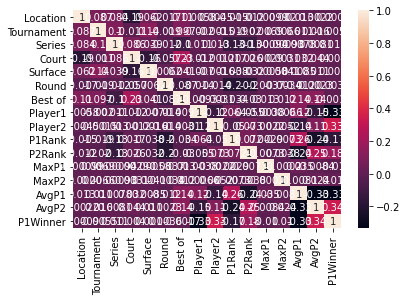

In [1201]:
sn.heatmap(corrMatrix, annot=True)
plt.show() 

## Models

In [1258]:
X=normalized_df.drop(["P1Winner"],axis=1)
y=normalized_df["P1Winner"]

#knn=neighbors.KNeighborsClassifier(n_neighbors=25,weights='uniform')
model = svm.SVC(gamma="auto",kernel='linear')

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

model.fit(X_train,y_train)

prediction=model.predict(X_test)

accuracy = metrics.accuracy_score(y_test,prediction)

print("prediction",prediction)
print("accuracy: ",accuracy)

prediction [1 1 1 ... 1 1 1]
accuracy:  0.7567510990161189


## Improve dataset

### Import player dataset and first clean

In [1087]:
df_players=pd.read_csv('player_overviews.csv')
df_players=df_players.drop(df_players.columns[4:17],axis=1)
df_players.head()
df_players.columns=['AtpId','AtpName','FirstName','Name','height','handedness','backhand']
df_players.head()

,AtpId,AtpName,FirstName,Name,height,handedness,backhand
0,a001,sadiq-abdullahi,Sadiq,Abdullahi,0.0,NaN,NaN
1,a005,nelson-aerts,Nelson,Aerts,188.0,NaN,NaN
2,a004,egan-adams,Egan,Adams,178.0,NaN,NaN
3,a006,ronald-agenor,Ronald,Agenor,180.0,NaN,NaN
4,a007,juan-aguilera,Juan,Aguilera,183.0,NaN,NaN


In [1088]:
df_total_players[df_total_players['Name'].str.contains('Foki')]
#df_merge[df_merge['Name'].str.contains('Foki')]

,AtpId,AtpName,Name,height,handedness,backhand
10980,dh50,alejandro-davidovich-fokina,Davidovich Fokina A.,NaN,NaN,NaN


In [1089]:
def Scrap():
    AtpIdList=[]
    AtpNameList=[]
    FirstNameList=[]
    LastNameList=[]
    atpRank='https://www.atptour.com/en/rankings/singles/?rankDate=2020-9-14&countryCode=all&rankRange=0-700'
    req = Request(atpRank, headers={'User-Agent': ''})
    webpageAtp = urlopen(req).read()
    soup = BeautifulSoup(webpageAtp, 'html.parser')
    for i in range(0,700):
        url_overview='https://www.atptour.com' + soup.select('.player-cell a')[i]['href']
        AtpName=url_overview.split("/")[5]
        AtpId=url_overview.split("/")[6]
        
        req2 = Request(url_overview, headers={'User-Agent': 'Mozilla/5.0'})
        webpage_overview = urlopen(req2).read()
        soup2 = BeautifulSoup(webpage_overview, 'html.parser')
        try:
            FirstName = soup2.find( attrs={'class': 'first-name'}).get_text()
        except AttributeError:
            FirstName=np.nan
        
        try:
            Name = soup2.find( attrs={'class': 'last-name'}).get_text()
        except AttributeError:
            Name=np.nan
            
        AtpIdList.append(AtpId)
        AtpNameList.append(AtpName)
        FirstNameList.append(FirstName)
        LastNameList.append(Name)
        
        Dictionnary={'AtpId':AtpIdList,'AtpName':AtpNameList,'FirstName':FirstNameList,'Name':LastNameList,'height':np.nan,'handedness':np.nan,'backhand':np.nan}

    return Dictionnary

In [1090]:
df_scrap=Scrap()
df_scrap=pd.DataFrame(df_scrap)
df_total_players=pd.concat([df_players, df_scrap], ignore_index=True)
df_total_players.drop_duplicates(subset ="AtpId",keep = "first", inplace = True) # KEEP UNIQUE VALUES
print(df_total_players.shape)

(11188, 7)


### Change Name syntax to be similar to global_dateset

In [1092]:
def PlayerName(Name,FirstName):
    length= len(Name)
    if "-" in FirstName:
        FirstName=FirstName.split("-")
        player=Name+' '+FirstName[0][0]+'.'+FirstName[1][0]+'.'
    elif " " in FirstName:
        FirstName=FirstName.split()
        if len(FirstName)>1:
            player=Name+' '+FirstName[0][0]+'.'+FirstName[1][0]+'.'
        else:
            player=Name+' '+FirstName[0]+'.'
    elif Name[length-1]=='.':
        player=Name+FirstName[0]+'.'
        
    else:
        player=Name+' '+FirstName[0]+'.'
    return player.title()

In [1094]:
df_total_players['Name']=df_total_players.apply(lambda x: PlayerName(x["Name"],x["FirstName"]), axis=1)
df_total_players=df_total_players.drop(["FirstName"],axis=1)
print(df_total_players['Name'].size)
df_total_players.head()

11188


,AtpId,AtpName,Name,height,handedness,backhand
0,a001,sadiq-abdullahi,Abdullahi S.,0.0,NaN,NaN
1,a005,nelson-aerts,Aerts N.,188.0,NaN,NaN
2,a004,egan-adams,Adams E.,178.0,NaN,NaN
3,a006,ronald-agenor,Agenor R.,180.0,NaN,NaN
4,a007,juan-aguilera,Aguilera J.,183.0,NaN,NaN


### CREATE DATAFRAME WITH ALL PLAYERS FROM GLOBAL DATASET

In [1096]:
players=pd.DataFrame({'Name':df_test['Winner']})
loser=pd.DataFrame({'Name':df_test['Loser']})


players=players.append(loser)

#players['Name']= players.apply(lambda x: checkName(x),axis=1)

players.drop_duplicates(subset ="Name",keep = "last", inplace = True) # KEEP UNIQUE VALUES
players.shape

(1304, 1)

### SCRAPING DATA FOR SELECTED PLAYERS 

In [1097]:
df_merge=pd.merge(players,df_total_players,on="Name")
df_merge.head()

,Name,AtpId,AtpName,height,handedness,backhand
0,Lu H.,l660,hao-lu,NaN,NaN,NaN
1,Fromberg R.,f164,richard-fromberg,196.0,NaN,NaN
2,Vinck C.,v175,christian-vinck,183.0,NaN,NaN
3,Tarango J.,t136,jeff-tarango,180.0,NaN,NaN
4,Damm M.,d214,martin-damm,188.0,NaN,NaN


In [1098]:
d=players[~players.Name.isin(df_merge.Name)]
print(d.shape)

(132, 1)


In [1099]:
print(df_merge.shape)

(1251, 6)


In [1100]:
print(df_merge["height"].isna().sum())
print(df_merge["handedness"].isna().sum())
print(df_merge["backhand"].isna().sum())

287
591
591


Height, Handedness and Backhand are interesting criterias to analyse but we have too many 'Nan' values. Thanks to the AtId and AtpNAme we can scrap on the website https://www.atptour.com/ 

In [1121]:
def scraping(atpId,atpName,height,handedness,backhand):
    url_atp = 'https://www.atptour.com/en/players/'+atpName+'/'+atpId+'/overview'
    req = Request(url_atp, headers={'User-Agent': 'Mozilla/5.0'})
    webpage = urlopen(req).read()
    soup = BeautifulSoup(webpage, 'html.parser')
    if ((height!=height) or (height==0.0)): #check NaN value
        try:
            height = soup.find( attrs={'class': 'table-height-cm-wrapper'}).get_text()
            height= height.replace('(','').replace(')','').replace('cm','')
        except AttributeError:
            height=np.nan
    else:
        height=height

    if handedness!=handedness: #check NaN value
        try:
            plays= soup.find_all( attrs={'class':"table-value"})
            if len(plays)>=2:
                plays=plays[2].get_text()
                if len(plays)>1:
                    plays=plays.split(", ")
                    
                    handedness=plays[0].replace("\r","")
                    handedness=handedness.replace("\n","")
                    if backhand != backhand:
                        backhand=plays[1].rstrip()
                    else:
                        backhand=backhand    
                else:
                    if backhand != backhand:
                        backhand=np.nan
                    else:
                        backhand=backhand 
                    handedness=plays[0].replace("\r","")
                    handedness=handedness.replace("\n","")
            else:
                handedness=np.nan
                if backhand != backhand:
                    backhand=np.nan
                else:
                    backhand=backhand
        except AttributeError:
            handedness=np.nan
            backhand=np.nan
    else:
        handedness=handedness
        if backhand != backhand:
            backhand=np.nan
        else:
            backhand=backhand
    if str(height)=='0':
        height=np.nan
    else:
        height=height
    if handedness=='':
        handedness=np.nan
    else:
        handedness=handedness
    
    return height,handedness,backhand

In [1122]:
df_merge[['ScrapHeight','ScrapHand','ScrapBack']]=df_merge.apply(lambda x : scraping(x['AtpId'],x['AtpName'],x['height'],x['handedness'],x['backhand']),axis=1,result_type="expand")
df_merge.head()

,Name,AtpId,AtpName,height,handedness,backhand,ScrapHeight,ScrapHand,ScrapBack
0,Lu H.,l660,hao-lu,NaN,NaN,NaN,NaN,Right-Handed,Unknown Backhand
1,Fromberg R.,f164,richard-fromberg,196.0,NaN,NaN,196,Right-Handed,Unknown Backhand
2,Vinck C.,v175,christian-vinck,183.0,NaN,NaN,183,Left-Handed,Unknown Backhand
3,Tarango J.,t136,jeff-tarango,180.0,NaN,NaN,180,Left-Handed,Unknown Backhand
4,Damm M.,d214,martin-damm,188.0,NaN,NaN,188,Right-Handed,Unknown Backhand


In [1123]:
df_merge["ScrapHeight"] = df_merge.ScrapHeight.astype(float)

In [1124]:
df_merge[df_merge['Name'].str.contains('Foki')]

,Name,AtpId,AtpName,height,handedness,backhand,ScrapHeight,ScrapHand,ScrapBack
1205,Davidovich Fokina A.,dh50,alejandro-davidovich-fokina,NaN,NaN,NaN,183.0,Right-Handed,Two-Handed Backhand


In [1125]:
#df_merge.iloc[10980]["Name"]
scraping('a280','henrik-andersson',np.nan,np.nan,np.nan)

(nan, 'Right-Handed', 'Unknown Backhand')

In [1126]:
df_merge[df_merge['height']==0.0]


,Name,AtpId,AtpName,height,handedness,backhand,ScrapHeight,ScrapHand,ScrapBack
11,Albert M.,a012,marc-albert,0.0,NaN,NaN,NaN,Right-Handed,Unknown Backhand
24,Agaev E.,a310,emin-agaev,0.0,NaN,NaN,NaN,Right-Handed,Unknown Backhand
70,Andersson H.,a280,henrik-andersson,0.0,NaN,NaN,NaN,Right-Handed,Unknown Backhand
109,Andersen J.,a741,jean-andersen,0.0,NaN,NaN,NaN,NaN,NaN
124,Abel M.,a391,maximilian-abel,0.0,NaN,NaN,NaN,Right-Handed,Unknown Backhand
158,Abdulla M.,a618,mohammed-abdulla,0.0,NaN,NaN,NaN,NaN,NaN
266,Auckland J.,a373,james-auckland,0.0,NaN,NaN,NaN,Right-Handed,Unknown Backhand
415,Agostinelli B.,a707,bruno-agostinelli,0.0,NaN,NaN,NaN,NaN,NaN
434,Aranguren J.M.,a502,juan-martin-aranguren,0.0,NaN,NaN,NaN,Right-Handed,Unknown Backhand
589,Authom M.,a789,maxime-authom,0.0,NaN,NaN,NaN,Right-Handed,Unknown Backhand


In [1259]:
#df_merge['height'].value_counts()

In [1260]:
#df_merge['ScrapHeight'].value_counts()

In [1129]:
print(df_merge['height'].isna().sum())
print(df_merge['ScrapHeight'].isna().sum())

287
197


In [1130]:
print(df_merge['handedness'].isna().sum())
print(df_merge['ScrapHand'].isna().sum())

591
100


In [1131]:

print(df_merge['backhand'].isna().sum())
print(df_merge['ScrapBack'].isna().sum())

591
100
